In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# --- 1. 計算関数の定義 ---

def compute_aa_and_aia(acc_matrix: list[list[float]]) -> tuple[list[float], list[float]]:
    """AA_kとAIA_kをそれぞれ計算する。"""
    AA_list = []
    AIA_list = []
    for k in range(len(acc_matrix)):
        current_accs = acc_matrix[k][:k+1]
        if not current_accs: continue
        AA_k = sum(current_accs) / len(current_accs)
        AA_list.append(AA_k)
        
        if not AA_list: continue
        AIA_k = sum(AA_list) / len(AA_list)
        AIA_list.append(AIA_k)
    return AA_list, AIA_list

def compute_fm(acc_matrix: list[list[float]]) -> list[float]:
    """Forgetting Measure (FM_k) を計算する。"""
    num_tasks = len(acc_matrix)
    if num_tasks == 0:
        return []
        
    fm_list = [0.0]  # Task 0 終了時点では忘却は発生しないので0
    
    for k in range(1, num_tasks):
        forgetting_sum = 0.0
        for j in range(k):
            # Task j に対する過去の最高精度を計算 (l < k)
            past_accs_on_j = [acc_matrix[l][j] for l in range(j, k) if j < len(acc_matrix[l])]
            if not past_accs_on_j: continue
            max_past_acc = max(past_accs_on_j)
            
            # 現在のTask jに対する精度
            if j >= len(acc_matrix[k]): continue
            current_acc = acc_matrix[k][j]
            
            # 忘却量を計算し、合計に加える
            forgetting_sum += (max_past_acc - current_acc)
            
        # Task k 終了時点での平均忘却量を計算
        avg_forgetting = forgetting_sum / k
        fm_list.append(avg_forgetting)
        
    return fm_list

def compute_im(acc_matrix: list[list[float]], joint_accs: list[float]) -> list[float]:
    """Intransigence Measure (IM_k) を計算する。"""
    num_tasks = len(acc_matrix)
    im_list = []

    for k in range(num_tasks):
        if k >= len(joint_accs) or k >= len(acc_matrix[k]):
            break
        a_k_star = joint_accs[k]      # 合同学習精度
        a_k_k = acc_matrix[k][k]      # 継続学習でタスクk学習直後の精度
        im_list.append(a_k_star - a_k_k) # 差を計算

    return im_list

# --- 2. 設定 ---

csv_directory = "/work/csv/uci-har/cil/"
csv_directory_im = "/work/csv/uci-har/cil-joint/" # Joint Trainingの結果CSVのパス
models_to_process = {
    "RNN": "rnn.csv",
    "CNN": "cnn.csv",
    "LSTM": "lstm.csv",
    "NCP": "ltc_ncps.csv" # モデル名をLTC_NCPSに変更
}
tasks = ["Task 0", "Task 1", "Task 2", "Task 3", "Task 4"]
num_tasks = len(tasks)
color_palette = {
    "CNN": "blue",
    "RNN": "green",
    "LSTM": "orange",
    "NCP": "red" # モデル名をLTC_NCPSに変更
}

# --- 3. データ処理と全指標の計算 ---

all_metrics_results = []
for model_name, file_name in models_to_process.items():
    file_path = os.path.join(csv_directory, file_name)
    if not os.path.exists(file_path):
        print(f"警告: ファイルが見つかりません: {file_path}")
        continue
        
    print(f"\n--- Processing model: {model_name} ---")
    df = pd.read_csv(file_path)
    # シェルスクリプトの実行順序に基づき、テスト精度のリストをそのまま使用
    accuracies = df['テスト精度 (Test Acc)'].tolist()
    
    acc_matrix = []

    # --- IM（非妥協性）の計算準備 ---
    joint_accuracies = []
    joint_file_path = os.path.join(csv_directory_im, file_name)
    if os.path.exists(joint_file_path):
        joint_df = pd.read_csv(joint_file_path)
        # 最初のNタスク分の精度を取得
        joint_accuracies = joint_df['テスト精度 (Test Acc)'].head(num_tasks).tolist()
    else:
        print(f"警告: Joint Trainingのファイルが見つかりません: {joint_file_path} (IMの計算はスキップされます)")

    # --- 精度マトリクス(acc_matrix)を構築 ---
    # CSVに記録された順序が正しいという前提でマトリクスを組み立てる
    current_pos = 0
    for k in range(num_tasks):
        num_evals = k + 1
        if 6 == len(accuracies):
            print(f"エラー: {model_name} のデータ数が不足しています。期待される行数に達していません。")
            break
        row = accuracies[current_pos : current_pos + num_evals]
        acc_matrix.append(row)
        current_pos += num_evals

    if not acc_matrix:
        continue

    # --- AA, AIA, FM, IM を計算 ---
    aa_list, aia_list = compute_aa_and_aia(acc_matrix)
    fm_list = compute_fm(acc_matrix)
    im_list = compute_im(acc_matrix, joint_accuracies)
    
    for k in range(len(aa_list)):
        all_metrics_results.append({
            "Model": model_name,
            "Task": k,
            "AA": aa_list[k],
            "AIA": aia_list[k],
            "FM": fm_list[k] if k < len(fm_list) else np.nan,
            "IM": im_list[k] if k < len(im_list) else np.nan,
            "Task 0 Acc": acc_matrix[k][0] if k < len(acc_matrix) and 0 < len(acc_matrix[k]) else np.nan
        })

metrics_df = pd.DataFrame(all_metrics_results)
print("\n--- Calculated Metrics (AA, AIA, FM, IM, Task 0 Acc) ---")
print(metrics_df)


--- Processing model: RNN ---

--- Processing model: CNN ---

--- Processing model: LSTM ---

--- Processing model: NCP ---

--- Calculated Metrics (AA, AIA, FM, IM, Task 0 Acc) ---
   Model  Task        AA       AIA        FM        IM  Task 0 Acc
0    RNN     0  0.877000  0.877000  0.000000  0.000000       0.877
1    RNN     1  0.866714  0.871857  0.000000  0.067143       0.877
2    RNN     2  0.868690  0.870802  0.023429  0.002000       0.763
3    RNN     3  0.834384  0.861697  0.102095 -0.023750       0.678
4    RNN     4  0.823629  0.854083  0.110045 -0.008571       0.644
5    CNN     0  0.832000  0.832000  0.000000  0.000000       0.832
6    CNN     1  0.851000  0.841500  0.000000 -0.002143       0.832
7    CNN     2  0.821452  0.834817  0.072071 -0.013500       0.690
8    CNN     3  0.808696  0.828287  0.087071  0.003333       0.635
9    CNN     4  0.787081  0.820046  0.113006  0.002500       0.543
10  LSTM     0  0.900000  0.900000  0.000000  0.000000       0.900
11  LSTM     

In [1]:
import pandas as pd
import os
import numpy as np

# --- 設定 ---
base_dir = "/work/csv/uci-har/cil_each"
models = ["RNN", "CNN", "LSTM", "NCP"]
seeds = [1, 2, 3, 4, 5]  # 使用するシード
num_tasks = 3

# 指標関数（既存関数を使用）
def compute_aa_and_aia(acc_matrix):
    AA_list, AIA_list = [], []
    for k in range(len(acc_matrix)):
        current_accs = acc_matrix[k][:k+1]
        AA_k = sum(current_accs) / len(current_accs)
        AA_list.append(AA_k)
        AIA_list.append(sum(AA_list)/len(AA_list))
    return AA_list, AIA_list

def compute_fm(acc_matrix):
    num_tasks = len(acc_matrix)
    if num_tasks == 0:
        return []

    fm_list = [0.0]  # Task1は忘却なし

    for k in range(1, num_tasks):  # Task2～TaskN
        forgetting_sum = 0.0
        for j in range(k):  # 過去タスク0～k-1
            # 過去タスク j の最大精度（逆三角形なので末尾からアクセス）
            past_accs_on_j = [acc_matrix[l][-(j+1)] for l in range(j, k)]
            max_past_acc = max(past_accs_on_j)
            # 現在タスク k の j 番目タスク精度
            current_acc = acc_matrix[k][-(j+1)]

            forgetting_sum += (max_past_acc - current_acc)
        fm_list.append(forgetting_sum / k)
        print(fm_list)
    return fm_list

def compute_im(acc_matrix, joint_accs):
    im_list = []
    for k in range(len(acc_matrix)):
        if k >= len(joint_accs) or k >= len(acc_matrix[k]):
            break
        a_k_star = joint_accs[k]
        a_k_k = acc_matrix[k][0]
        im_list.append(a_k_star - a_k_k)
    return im_list
all_metrics_results = []

for model_name in models:
    print(f"\n--- Processing model: {model_name} ---")
    accs_per_seed = []
    overall_accs_per_seed = []

    # --- 各シードの2回目 inferenceだけを抽出 ---
    for seed in seeds:
        file_path = os.path.join(base_dir, model_name.lower(), f"seed{seed}.csv")
        if not os.path.exists(file_path):
            print(f"警告: ファイルが存在しません: {file_path}")
            continue
        df = pd.read_csv(file_path)


        # 各タスクの 2 回目の inference
        inf2_index = df.groupby('task').nth(1).index if not df.empty else []
        df_filtered = df.drop(index=inf2_index)

        # --- 逆三角形 acc_matrix 用にテスト精度を抽出 ---
        acc_list = df_filtered['テスト精度 (Test Acc)'].tolist()
        accs_per_seed.append(acc_list)

    # --- overall_acc 用に 2回目 inference のみ抽出 ---
        if len(inf2_index) > 0:
            overall_accs_per_seed.append(df.loc[inf2_index, 'テスト精度 (Test Acc)'].tolist())
        else:
            overall_accs_per_seed.append([])
    if not accs_per_seed:
        continue

    # --- シード平均 ---
    max_len = max(len(lst) for lst in accs_per_seed)
    accs_avg = []
    for i in range(max_len):
        vals = [lst[i] for lst in accs_per_seed if i < len(lst)]
        accs_avg.append(sum(vals)/len(vals))
    
    # --- 逆三角形の acc_matrix 作成 ---
    acc_matrix = []
    current_pos = 0
    for k in range(num_tasks):
        row_len = k+1  # 下三角分だけ
        if current_pos + row_len > len(accs_avg):
            print(f"エラー: {model_name} のデータ数が不足")
            break
        acc_matrix.append(accs_avg[current_pos: current_pos + row_len])
        current_pos += row_len
    
    # --- joint accuracy (IM計算用) ---
    joint_accs_per_seed = []
    for seed in seeds:
        joint_file = os.path.join(base_dir, model_name.lower(), "joint", f"seed{seed}.csv")
        if os.path.exists(joint_file):
            joint_df = pd.read_csv(joint_file)
            joint_accs_per_seed.append(joint_df['テスト精度 (Test Acc)'].head(num_tasks).tolist())

    joint_accs_avg = [sum(vals)/len(vals) for vals in zip(*joint_accs_per_seed)] if joint_accs_per_seed else []
    print(acc_matrix)
    # --- 指標計算 ---
    aa_list, aia_list = compute_aa_and_aia(acc_matrix)
    fm_list = compute_fm(acc_matrix)
    im_list = compute_im(acc_matrix, joint_accs_avg)


    # --- overall_acc をシード平均で計算 ---
    overall_acc_avg = []
    # overall_accs_per_seed はリストのリスト [[seed1のinf2],[seed2のinf2],...]
    # transposeしてタスクごとに平均
    if overall_accs_per_seed and any(overall_accs_per_seed):
        max_len_overall = max(len(lst) for lst in overall_accs_per_seed)
        for i in range(max_len_overall):
            vals = [lst[i] for lst in overall_accs_per_seed if i < len(lst)]
            overall_acc_avg.append(sum(vals)/len(vals))
    else:
        overall_acc_avg = [np.nan]*num_tasks

    for k in range(len(aa_list)):
        all_metrics_results.append({
            "Model": model_name,
            "Task": k+1,
            "AA": aa_list[k],
            "AIA": aia_list[k],
            "FM": fm_list[k] if k < len(fm_list) else np.nan,
            "IM": im_list[k] if k < len(im_list) else np.nan,
            "Overall Acc": overall_acc_avg[k] if k < len(overall_acc_avg) else np.nan
        })

metrics_df = pd.DataFrame(all_metrics_results)
print(metrics_df)



--- Processing model: RNN ---
[[0.8809999942779541], [0.9667499899864197, 0.0], [0.9896000027656555, 0.0, 0.0029999999329447602]]
[0.0, 0.8809999942779541]
[0.0, 0.8809999942779541, 0.9223749921657145]

--- Processing model: CNN ---
[[0.6729999780654907], [0.4562499523162842, 0.0], [0.9674000024795533, 0.0, 0.0]]
[0.0, 0.6729999780654907]
[0.0, 0.6729999780654907, 0.5646249651908875]

--- Processing model: LSTM ---
[[0.9464999914169312], [0.9690000057220459, 0.0], [0.9899999976158143, 0.0, 0.0177500000223517]]
[0.0, 0.9464999914169312]
[0.0, 0.9464999914169312, 0.9488749985583127]

--- Processing model: NCP ---
[[0.9267499923706055], [0.9667499899864197, 0.199399995803833], [0.7965999960899353, 0.0, 0.0]]
[0.0, 0.7273499965667725]
[0.0, 0.7273499965667725, 0.9467499911785127]
   Model  Task        AA       AIA        FM        IM  Overall Acc
0    RNN     1  0.881000  0.881000  0.000000  0.000000     0.881000
1    RNN     2  0.483375  0.682187  0.881000 -0.040861     0.460556
2    RNN

/tmp/ipykernel_4174161/772427790.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


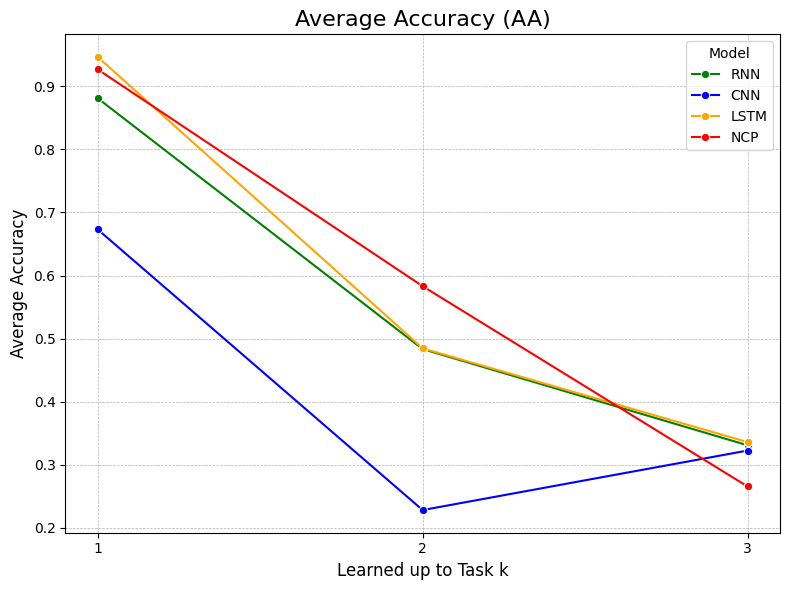

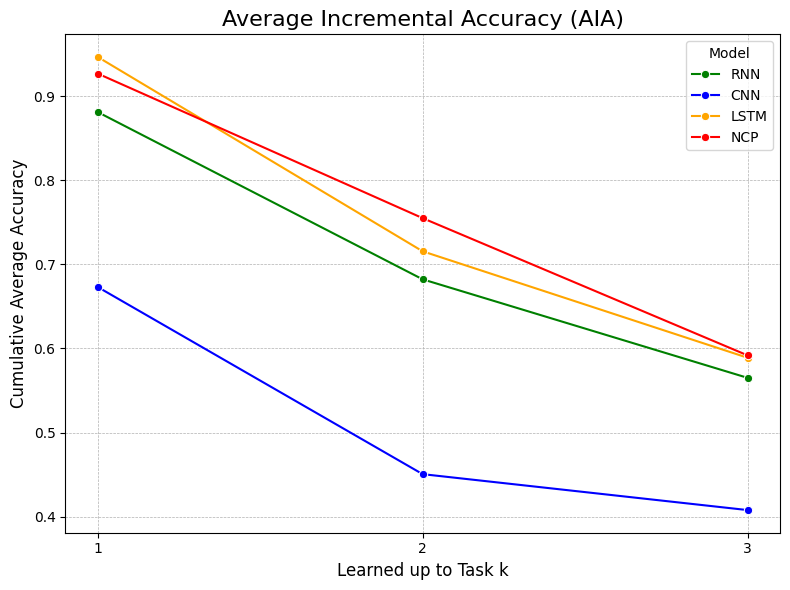

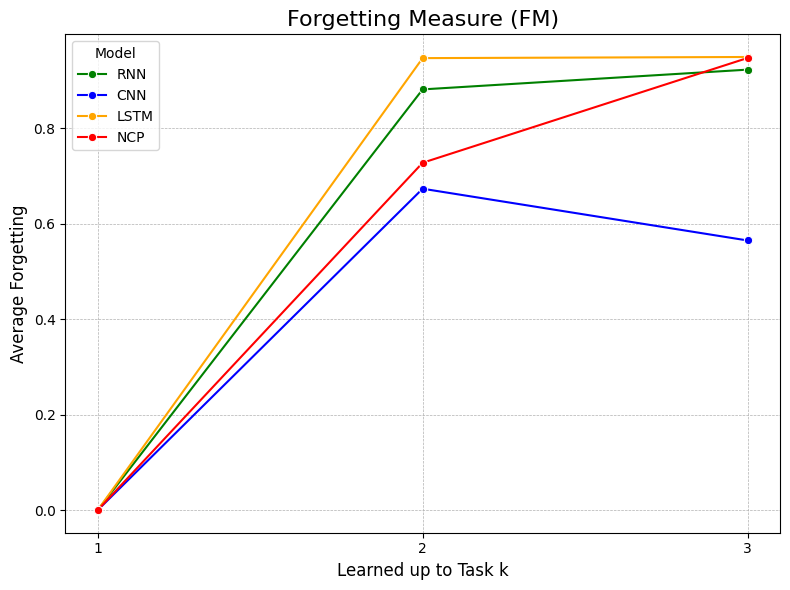

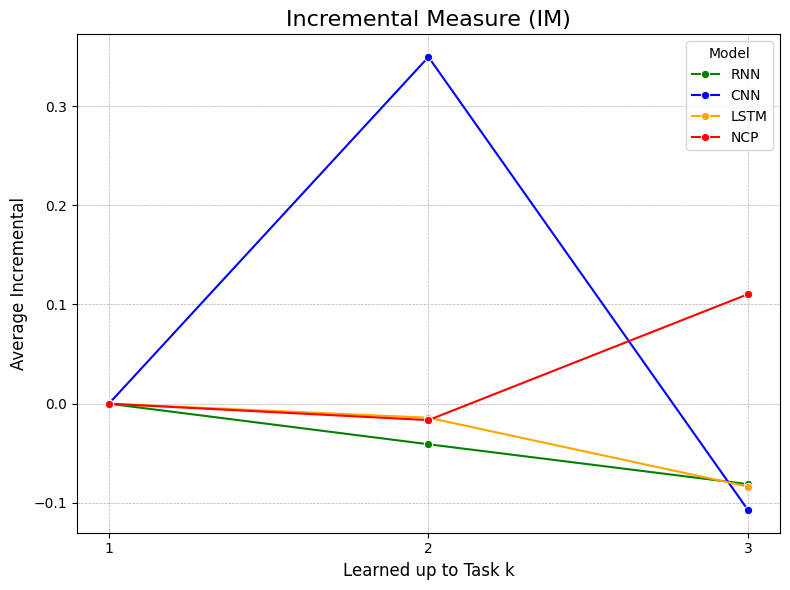

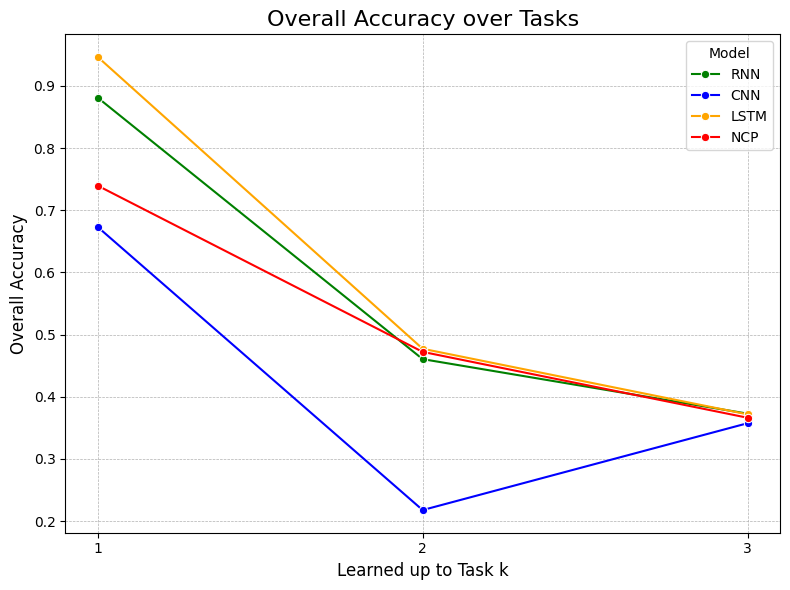

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

color_palette = {
    "CNN": "blue",
    "RNN": "green",
    "LSTM": "orange",
    "NCP": "red" 
}
# --- AA ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Task", y="AA", hue="Model", palette=color_palette, marker="o")
plt.title("Average Accuracy (AA)", fontsize=16)
plt.xlabel("Learned up to Task k", fontsize=12)
plt.ylabel("Average Accuracy", fontsize=12)
plt.xticks(range(1, num_tasks+1))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- AIA ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Task", y="AIA", hue="Model", palette=color_palette, marker="o")
plt.title("Average Incremental Accuracy (AIA)", fontsize=16)
plt.xlabel("Learned up to Task k", fontsize=12)
plt.ylabel("Cumulative Average Accuracy", fontsize=12)
plt.xticks(range(1, num_tasks+1))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- FM ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Task", y="FM", hue="Model", palette=color_palette, marker="o")
plt.title("Forgetting Measure (FM)", fontsize=16)
plt.xlabel("Learned up to Task k", fontsize=12)
plt.ylabel("Average Forgetting", fontsize=12)
plt.xticks(range(1, num_tasks+1))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- IM ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Task", y="IM", hue="Model", palette=color_palette, marker="o")
plt.title("Incremental Measure (IM)", fontsize=16)
plt.xlabel("Learned up to Task k", fontsize=12)
plt.ylabel("Average Incremental", fontsize=12)
plt.xticks(range(1, num_tasks+1))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- Task 0 Acc ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Task", y="Overall Acc", hue="Model", palette=color_palette, marker="o")
plt.title("Overall Accuracy over Tasks", fontsize=16)
plt.xlabel("Learned up to Task k", fontsize=12)
plt.ylabel("Overall Accuracy", fontsize=12)
plt.xticks(range(1, num_tasks+1))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()